In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Library Code

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

###Check dataset

In [3]:
sdir=r'/content/drive/MyDrive/Casptone Project - Tourify /Machine Learning/CV_Images'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths        labels
0  /content/drive/MyDrive/Casptone Project - Tour...  Rumah boneka
1  /content/drive/MyDrive/Casptone Project - Tour...  Rumah boneka
2  /content/drive/MyDrive/Casptone Project - Tour...  Rumah boneka
3  /content/drive/MyDrive/Casptone Project - Tour...  Rumah boneka
4  /content/drive/MyDrive/Casptone Project - Tour...  Rumah boneka
masjid istiqlal           48
keong emas                44
Rumah boneka              37
museum nasional           37
Monumen Nasional          33
Patung Sudirman           32
Monumen Selamat Datang    30
Name: labels, dtype: int64


###Division of Data into Training, Testing, and Validation Sets

In [4]:
  train_split=.8
  test_split=.1
  dummy_split=test_split/(1-train_split)
  train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
  test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
  print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  208   test_df length:  26   valid_df length:  27


###Data Preprocessing and Image Augmentation using ImageDataGenerator

In [5]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'

    )

train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255,rotation_range=15)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255,rotation_range=15)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  26   test steps:  1
Found 207 validated image filenames belonging to 7 classes.
Found 27 validated image filenames belonging to 7 classes.
Found 26 validated image filenames belonging to 7 classes.
['Monumen Nasional', 'Monumen Selamat Datang', 'Patung Sudirman', 'Rumah boneka', 'keong emas', 'masjid istiqlal', 'museum nasional']


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


###Sample Images from the Training Generator (train_gen)

In [6]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

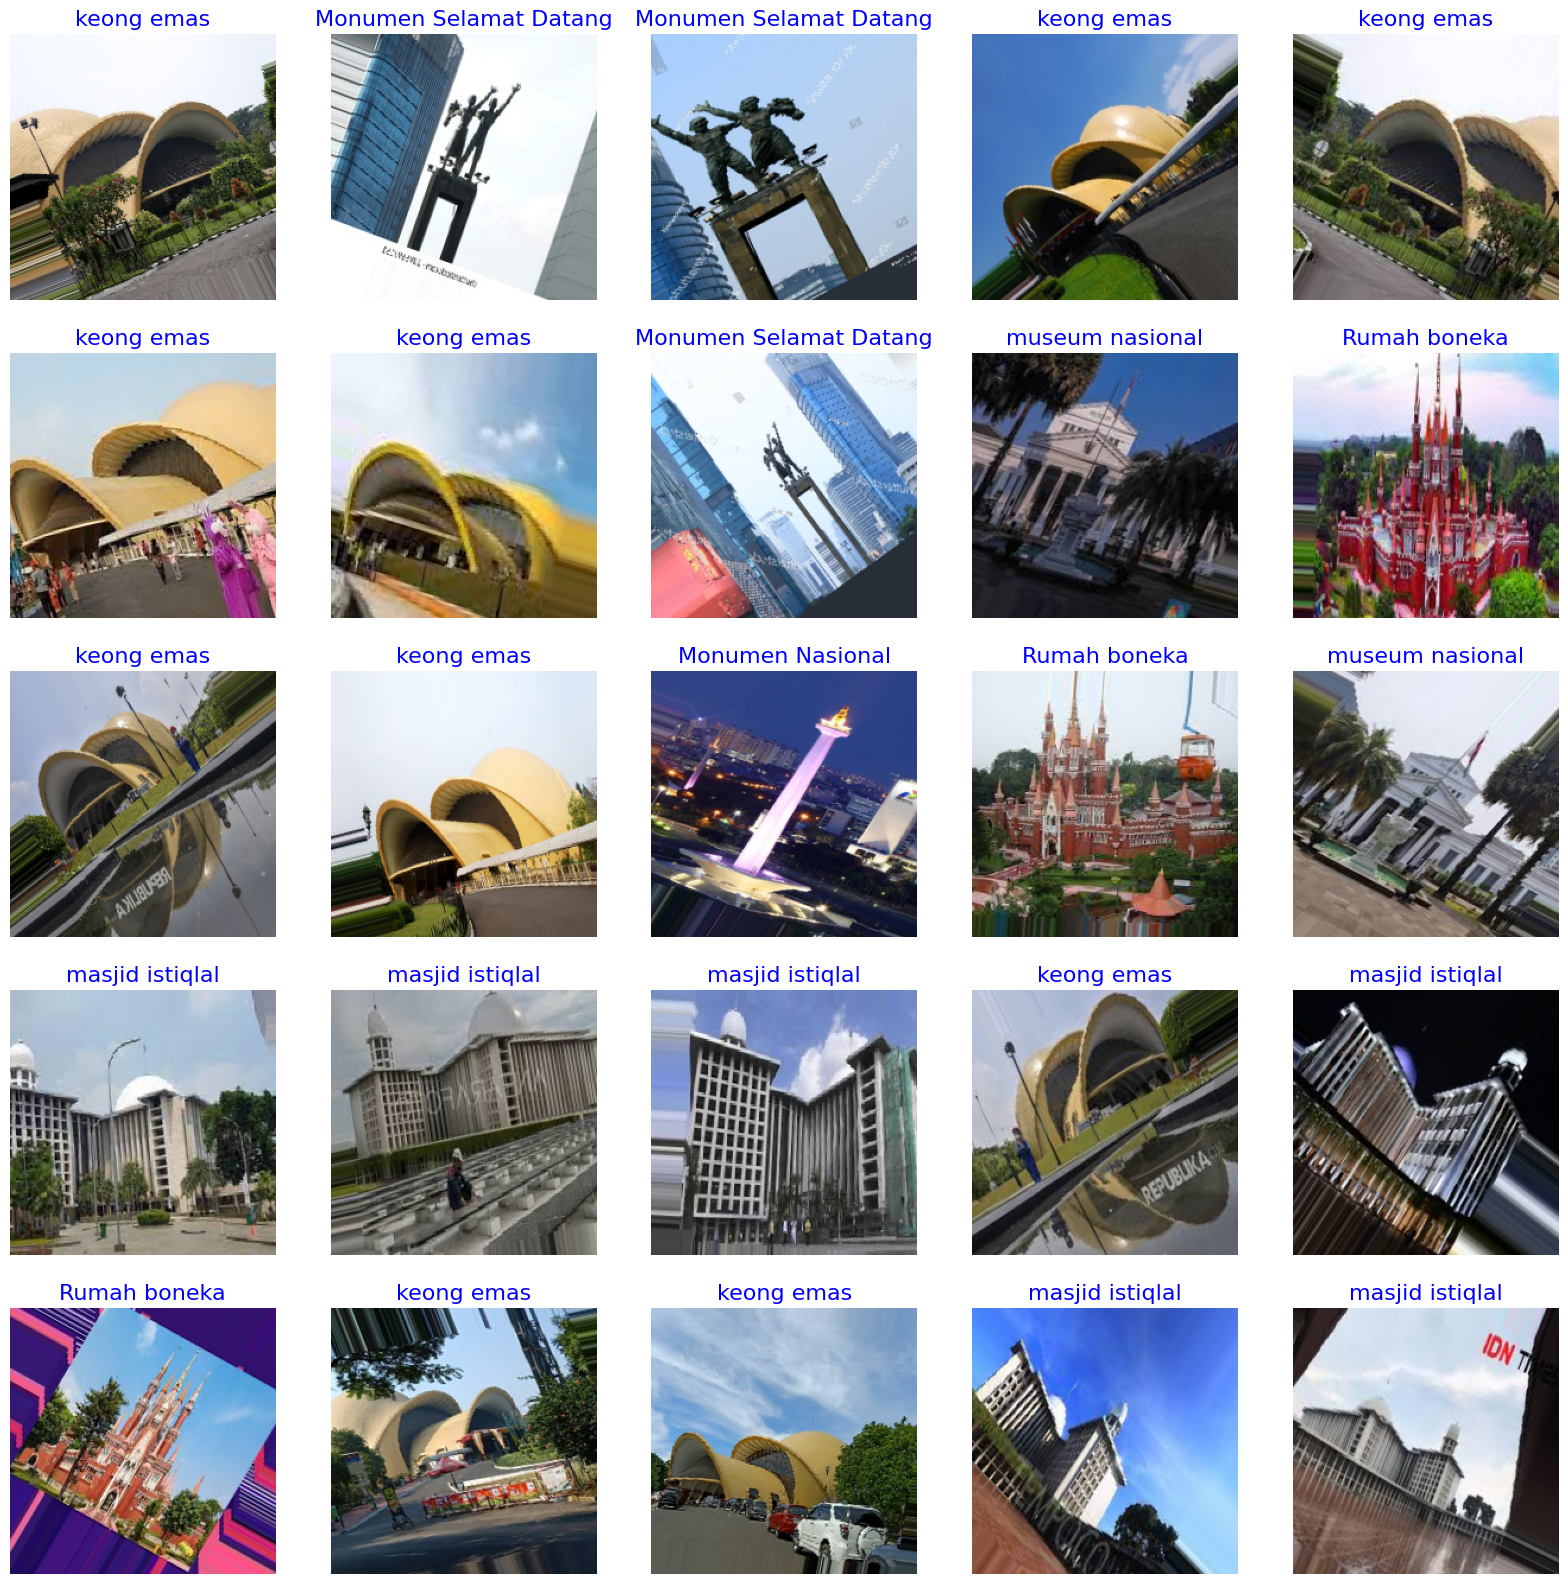

In [7]:
show_image_samples(train_gen)

###Build and Train a Model for Object Classification using Xception as Base Model

In [8]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

83683744/83683744 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [10]:
base_model.trainable = False

In [11]:
model_name='Clarifikasi_objek'
print("Building model with", base_model)

class trCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.99:
            print(" accuracy and validation_accuracy > 99%")
            self.model.stop_training = True

model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(7, activation='softmax')
])

callbacks = trCallback()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x7f506430c700>


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 7)                 2023      
                                                        

In [13]:
epochs = 50

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/50
4/4 [==============================] - 57s 16s/step - loss: 2.1408 - accuracy: 0.2899 - val_loss: 1.6305 - val_accuracy: 0.3704
Epoch 2/50
4/4 [==============================] - 7s 2s/step - loss: 1.4611 - accuracy: 0.4155 - val_loss: 1.4101 - val_accuracy: 0.4444
Epoch 3/50
4/4 [==============================] - 5s 1s/step - loss: 1.3983 - accuracy: 0.4444 - val_loss: 1.2591 - val_accuracy: 0.5556
Epoch 4/50
4/4 [==============================] - 4s 956ms/step - loss: 1.2136 - accuracy: 0.4976 - val_loss: 1.1112 - val_accuracy: 0.5926
Epoch 5/50
4/4 [==============================] - 6s 2s/step - loss: 1.1697 - accuracy: 0.5556 - val_loss: 1.0098 - val_accuracy: 0.7037
Epoch 6/50
4/4 [==============================] - 4s 959ms/step - loss: 0.9339 - accuracy: 0.7150 - val_loss: 0.6576 - val_accuracy: 0.8148
Epoch 7/50
4/4 [==============================] - 4s 948ms/step - loss: 0.7373 - accuracy: 0.7295 - val_loss: 0.3864 - val_accuracy: 0.9259
Epoch 8/50
4/4 [==============

###Model Evaluation and Result Visualisation for Object Classification

In [14]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

In [15]:
def tr_plot(tr_data, start_epoch):

    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

    plt.show()


In [16]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key

    classes=list(new_dict.values())
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))

        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count)
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:

        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

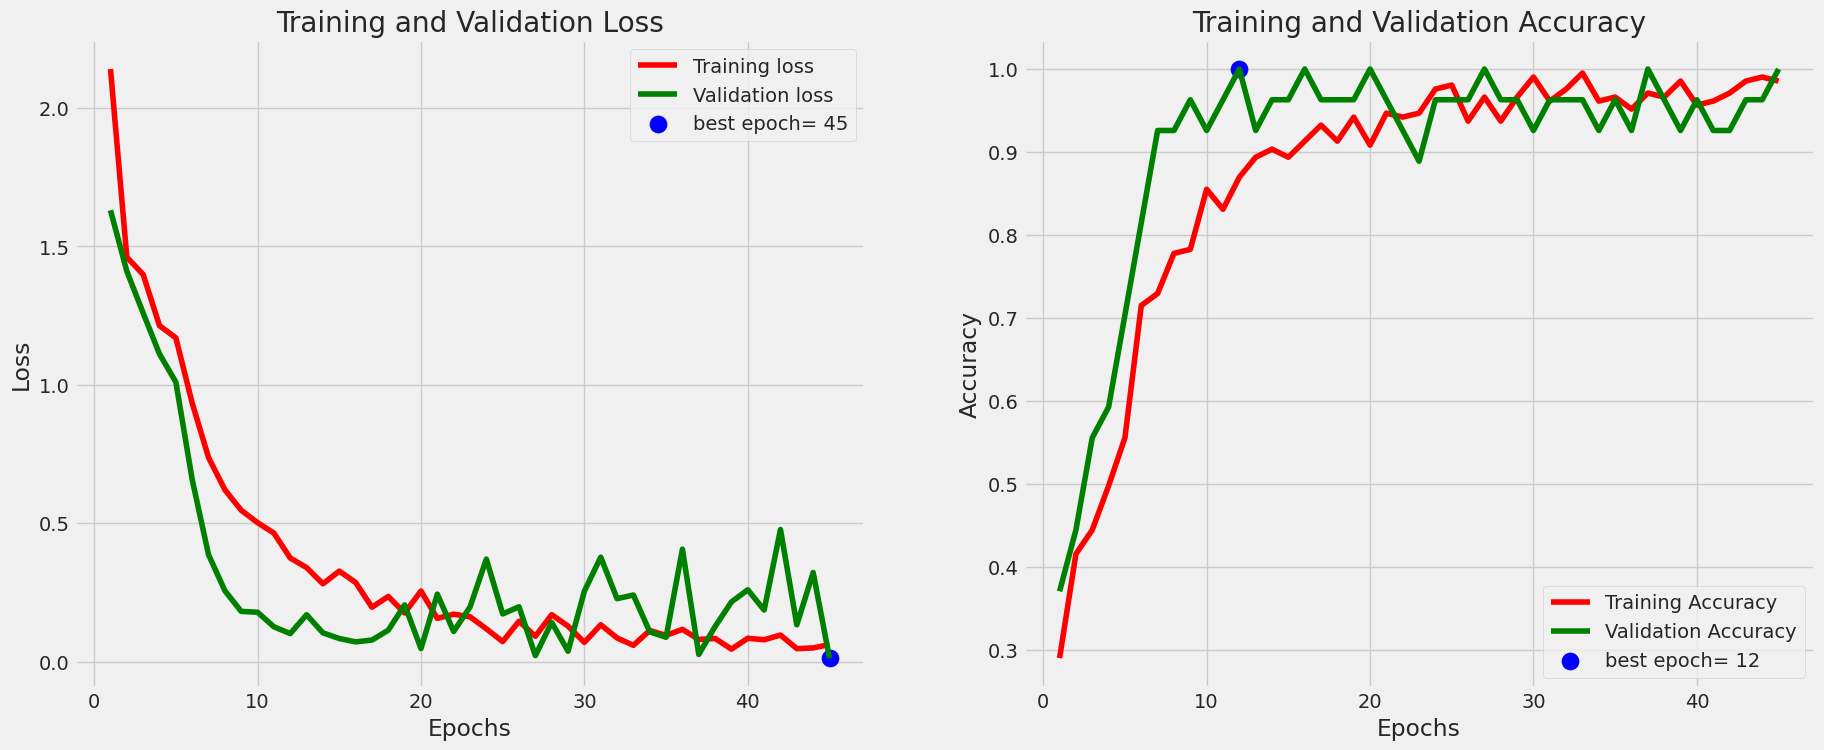

1/1 [==============================] - 3s 3s/step - loss: 0.0076 - accuracy: 1.0000
accuracy on the test set is 100.00 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
tr_plot(history,0)
save_dir=r'./'
subject='wisata'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

1/1 [==============================] - 1s 1s/step


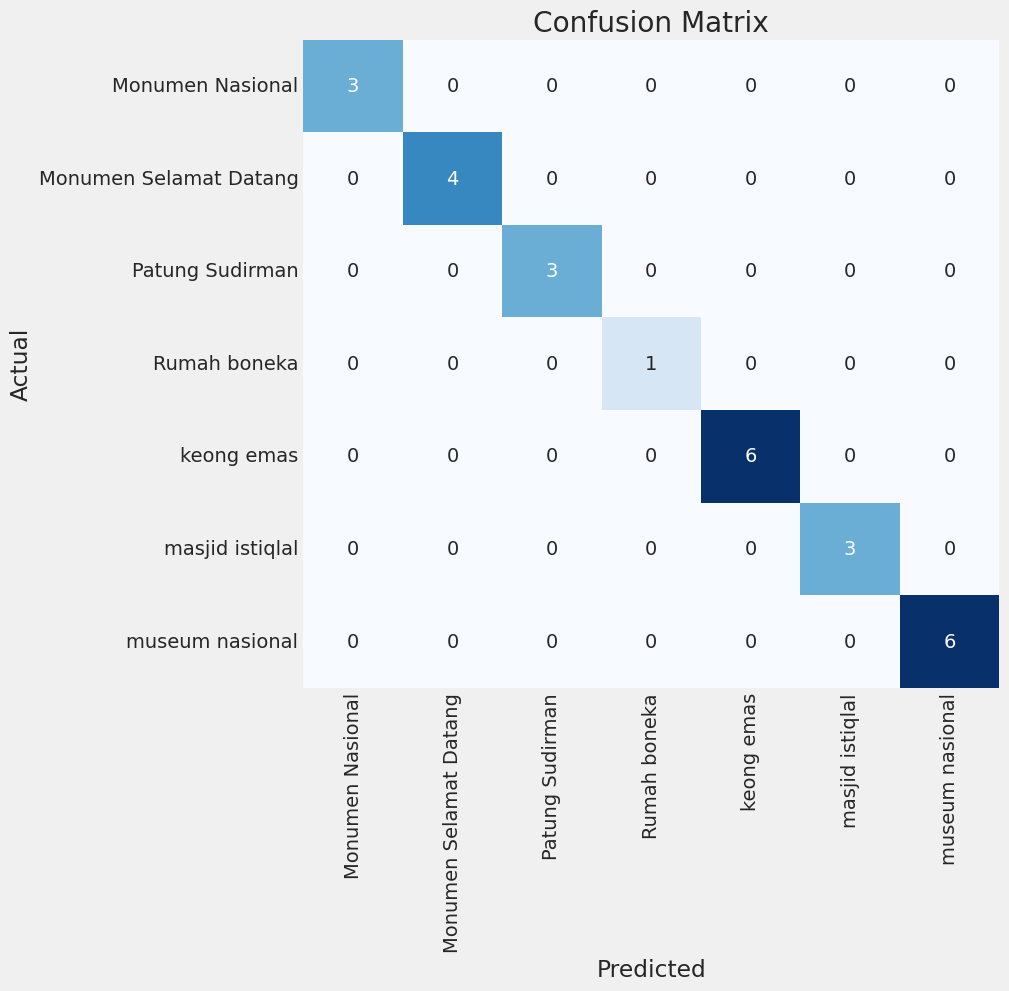

Classification Report:
----------------------
                         precision    recall  f1-score   support

      Monumen Nasional       1.00      1.00      1.00         3
Monumen Selamat Datang       1.00      1.00      1.00         4
       Patung Sudirman       1.00      1.00      1.00         3
          Rumah boneka       1.00      1.00      1.00         1
            keong emas       1.00      1.00      1.00         6
       masjid istiqlal       1.00      1.00      1.00         3
       museum nasional       1.00      1.00      1.00         6

              accuracy                           1.00        26
             macro avg       1.00      1.00      1.00        26
          weighted avg       1.00      1.00      1.00        26



In [18]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

###image prediction

In [20]:
# Load trained model
model = load_model('/content/Clarifikasi_objek-wisata-100.0.h5')

# Load and preprocess the image
img_path = '/content/images (49).jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make prediction
prediction = model.predict(img_array)

# Convert the prediction to class labels
predicted_class = np.argmax(prediction)
class_labels = ['Monumen Nasional', 'Teater IMAX Keong Mas', 'Patung Sudirman', 'Taman Fatahillah', 'Masjid Istiqlal', 'Monumen Selamat Datang', 'Museum Nasional']
predicted_label = class_labels[predicted_class]

# Load data from CSV
csv_path = '/content/drive/MyDrive/Casptone Project - Tourify /Machine Learning/CV_Images/DatasetTourify - Sheet1.csv'  # Ganti dengan path file CSV Anda
df = pd.read_csv(csv_path)

# Map class labels to captions from the CSV file
class_captions = dict(zip(df['Object'], df['Caption']))

# Display the prediction
print("Predicted Class:", predicted_class)
print("Predicted Label:", predicted_label)

# Display the corresponding caption from the CSV file
predicted_caption = class_captions.get(predicted_label, "Caption tidak tersedia")
print("Predicted Caption:", predicted_caption)


1/1 [==============================] - 3s 3s/step
Predicted Class: 3
Predicted Label: Taman Fatahillah
Predicted Caption: Taman Fatahillah (sebelumnya bernama Stadhuisplein) adalah sebuah lapangan yang berada di kawasan pusat Kota Tua Jakarta. Di tempat ini berdiri beberapa bangunan tua seperti bekas Balai Kota Jakarta (sekarang Museum Fatahillah), Museum Wayang, Kantor Pos Kota, dan bekas gedung Pengadilan Tinggi Batavia (sekarang Museum Seni Rupa dan Keramik). Tempat ini dinamakan Fatahillah, seorang tokoh yang berhasil merebut Sunda Kelapa dari tangan Portugis


###convert h5 to json

In [21]:
# Convert the model to JSON format
model_json = model.to_json()

# Save the JSON representation to a file
with open('/content/Clarifikasi_objek-wisata_model.json', 'w') as json_file:
    json_file.write(model_json)